## Aim: To compare a baseline model to a Convolutional Neural Network (CNN) in the classification of images from the FashionMNIST data



#### Let's import our dependencies

In [78]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

#### We will proceed to download the data

In [79]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    transform = ToTensor(),
    download = True,
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    transform = ToTensor(),
    train = False,
    target_transform = None,
)

In [80]:
len(train_data), len(test_data)

(60000, 10000)

In [81]:
len(train_data.data), len(train_data.targets)

(60000, 60000)

In [82]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

#### Let's view one of the images

In [83]:
image, label = train_data[0]

In [84]:
image.shape

torch.Size([1, 28, 28])

In [85]:
label

9

In [86]:
class_names[label]

'Ankle boot'

Text(0.5, 1.0, 'Ankle boot')

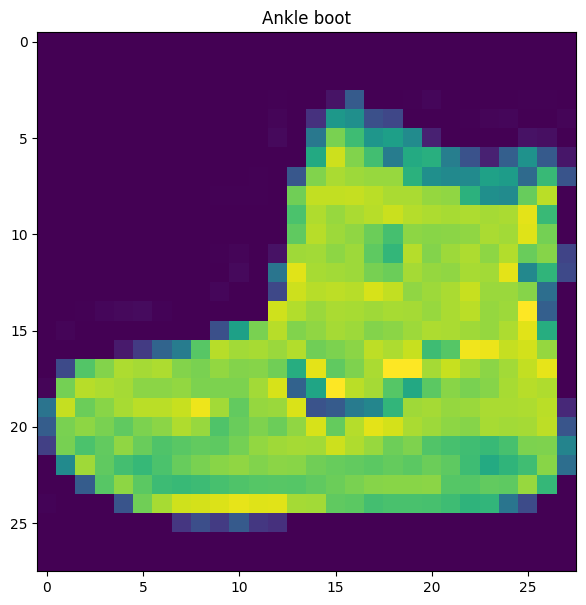

In [87]:
plt.figure(figsize=(10,7))
plt.imshow(image.squeeze())
plt.title(class_names[label])

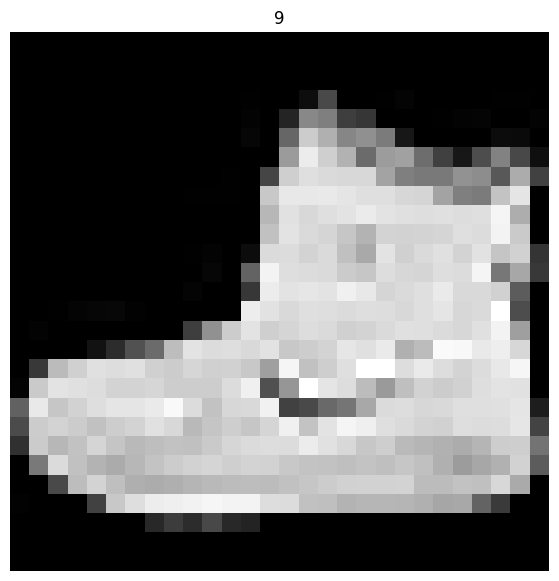

In [88]:
plt.figure(figsize=(10,7))
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(label)
plt.axis(False);

#### Let's proceed to view random images from our data

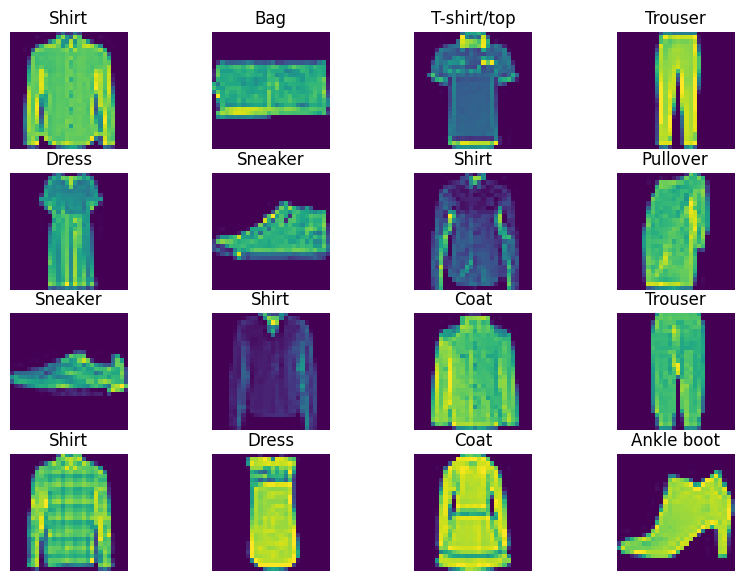

In [89]:
figure = plt.figure(figsize=(10, 7))
rows = 4
cols = 4
for i in range(1,rows*cols+1):
  random_idx = torch.randint(1, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  figure.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze())
  plt.title(class_names[label])
  plt.axis(False);

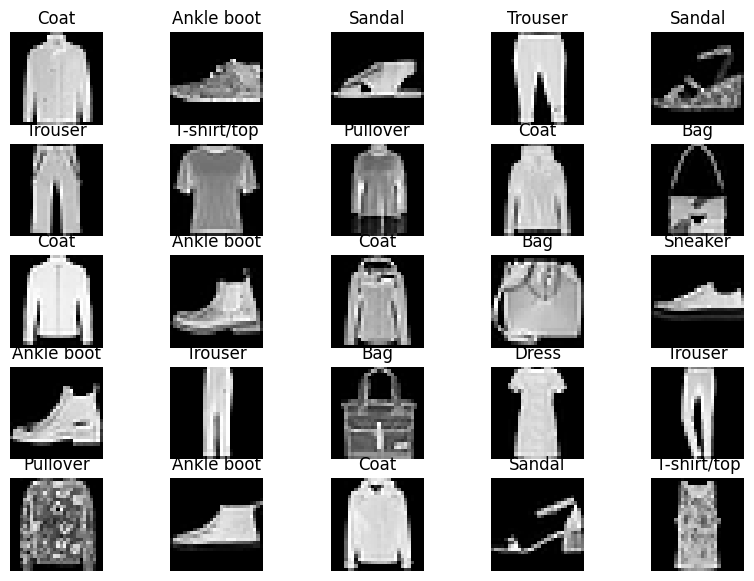

In [90]:
figure = plt.figure(figsize=(10,7))
rows, cols = 5,5
for i in range(1, rows*cols+1):
  random_idx = torch.randint(1, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  figure.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap = "gray")
  plt.title(class_names[label])
  plt.axis(False);

#### Great! Let's proceed to load our data in batches. We will train the data per batch within each epoch (forward pass)


In [91]:
from torch.utils.data import DataLoader

In [92]:
train_batches = DataLoader(
    train_data,
    batch_size = 32, # A batch_size of 32 is good. But this is an hyperparameter that can be changed e.g 32, 64, 128, 256, 512
    shuffle = True
)

test_batches = DataLoader(
    test_data,
    batch_size = 32,
)

print(f"There are {len(train_batches)} batches of {len(train_batches.dataset)} samples")
print(f"There are {len(test_batches)} batches of {len(test_batches.dataset)} samples")

There are 1875 batches of 60000 samples
There are 313 batches of 10000 samples


In [93]:
train_batches.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [94]:
len(train_batches.dataset)

60000

#### Great , we have our data ready in batches and already splitted. We can proceed to view one of the images in the batches and then build our model

In [95]:
image, label = train_batches[0][0]

TypeError: 'DataLoader' object is not subscriptable

We are not able to select directly from the train_batches because we need to return it as an iterable

In [ ]:
train_batches_images, train_batches_labels = next(iter(train_batches))

In [ ]:
image, label = train_batches_images[0], train_batches_labels[0]

In [ ]:
print(f"Each image has the shape: {image.shape}")

In [ ]:
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)
plt.show();

#### Great! We can now proceed to build our model. First we'll build the baseline model

In [ ]:
from torch import nn

In [163]:
class BaseLineModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten() # allows us convert our image to a single feature vector
    self.linear_layer = nn.Linear(in_features = 784, out_features= 10)
    self.linear_layer_1 = nn.Linear(in_features = 10, out_features = len(class_names))

  def forward(self, x:torch.Tensor):
    return self.linear_layer_1(self.linear_layer(self.flatten(x)))

In [164]:
torch.manual_seed(42)
model_0 = BaseLineModel()

In [165]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_0.parameters(),
                            lr = 0.01)
try:
  import torchmetrics
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy
  accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names))

In [166]:
def train_test_model(epochs: int,
                     model: torch.nn.Module,
                     train_dataloader: torch.utils.data.DataLoader,
                     test_dataloader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     accuracy_fn
                     ):
    """
    Function that takes a model, dataloaders, loss function, optimizer, and an accuracy function and returns model predictions following training and testing
    """
    from tqdm.auto import tqdm

    train_loss, train_acc= 0, 0
    for epoch in tqdm(range(epochs)):
      for batch, (X,y) in enumerate(train_dataloader):
        model.train()
        # Model training
        logits = model_0(X)
        y_preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        # calculate the loss
        loss = loss_fn(logits, y)
        train_loss += loss
        train_acc += accuracy_fn(y_preds, y)

        # Zero the gradients
        optimizer.zero_grad()

        # Perfrom backpropagation
        loss.backward()

        # Step the optimizer
        optimizer.step()


      train_loss /= len(train_batches)
      train_acc /= len(train_batches)

      print(f"Epoch: {epoch} | Train loss: {train_loss} | Train accuracy: {train_acc}")
      with torch.inference_mode():
        model.eval()
        test_loss, test_acc = 0,0
        for X,y in test_dataloader:
          test_logits = model(X)

          test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

          test_loss = loss_fn(test_logits, y)
          test_acc = accuracy_fn(y, test_preds)

      print(f"Epoch: {epoch} | Test loss: {test_loss} | Test accuracy: {test_acc}")




In [167]:
train_test_model(epochs=3,
                 model=model_0,
                 train_dataloader = train_batches,
                 test_dataloader= test_batches,
                 loss_fn=loss_fn,
                 optimizer=optimizer,
                 accuracy_fn = accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9086608290672302 | Train accuracy: 0.7075499892234802
Epoch: 0 | Test loss: 0.38089773058891296 | Test accuracy: 0.9375
Epoch: 1 | Train loss: 0.5575246214866638 | Train accuracy: 0.8121106624603271
Epoch: 1 | Test loss: 0.32175177335739136 | Test accuracy: 0.875
Epoch: 2 | Train loss: 0.502638578414917 | Train accuracy: 0.8283831477165222
Epoch: 2 | Test loss: 0.30707165598869324 | Test accuracy: 0.875


#### Next, we will build the TinyVGG, CNN architecture by replicating the arcitecture from the CNN Explainer website.